In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import json
import gpytorch
import torch
import tqdm
import os
import threading
import concurrent
import logging

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
from time import sleep
from typing import List, Union
from math import ceil


%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [3]:
def flatten_dict(x: dict, prefix=""):
    y = {}
    for k, v in x.items():
        if isinstance(v, dict):
            y.update(flatten_dict(v, k + "_"))
        else:
            y[prefix + k] = v
    return y

In [4]:
class ReturnValueThread(threading.Thread):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.result = None

    def run(self):
        if self._target is None:
            return  # could alternatively raise an exception, depends on the use case
        try:
            self.result = self._target(*self._args, **self._kwargs)
        except Exception as exc:
            print(f'{type(exc).__name__}: {exc}', file=sys.stderr)  # properly handle the exception

    def join(self, *args, **kwargs):
        super().join(*args, **kwargs)
        return self.result

In [5]:
def preprocess(data_paths, include_dirs, max_workers: int = 64):
        
    all_tasks = []
    num_tasks = len(include_dirs)
        
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        for path in data_paths:
            for folder in os.listdir(path):
                all_tasks.append(executor.submit(subprocess, path, folder))
            for future in tqdm.tqdm(concurrent.futures.as_completed(all_tasks), total=num_tasks):
                try:
                    data = future.result()
                        
                except Exception as e:
                    logging.error(e)

def subprocess(path, folder):   

    if int(folder) not in include_dirs:
        return

    chassis_file = os.path.join(path, folder, "env_learning_zip/chassis.txt")
    control_file = os.path.join(path, folder, "env_learning_zip/control.txt")
    localization_file = os.path.join(path, folder, "env_learning_zip/localization.txt")
    
    a= num_lines(chassis_file)
    b= num_lines(control_file)
    c= num_lines(localization_file)

    if a != b or b != c or c != a or a == 0:
        return

    to_csv(chassis_file, os.path.join(path, folder, "preprocessed/chassis.csv"))
    to_csv(control_file, os.path.join(path, folder, "preprocessed/control.csv"))
    to_csv(localization_file, os.path.join(path, folder, "preprocessed/localization.csv"))


    
def to_csv(file, dest):
    df = pd.DataFrame()
    with open(file) as file:
        for line in file:
            nested_dict = json.loads(line)
            df = pd.concat([df, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
    df.to_csv(dest)

def num_lines(abs_path):
    num = 0
    if not os.path.exists(abs_path):
        return num

    with open(abs_path) as file:
        for line in file:
            num += 1

    return num

    

In [6]:
class DataLoader():
    def __init__(
        self,
        data_paths,
        include_dirs=None,
        batch_size=1000
    ):
        self.data_paths = data_paths
        self.chassis_df = pd.DataFrame()
        self.control_df = pd.DataFrame()
        self.localization_df = pd.DataFrame()
        self.include_dirs = include_dirs
        self.batch_size=batch_size
        
    def load_data(self):
        batch_index = 0
        tmp1 = []
        tmp2 = []
        tmp3 = []
        tmp4 = []
        
        with tqdm.notebook.tqdm(total=len(self.include_dirs)) as pbar:
            pbar.set_description('Processing:')
            for p in self.data_paths:
                for folder in os.listdir(p):
                    pbar.update(1)
                    if folder not in self.include_dirs:
                        continue

                    chassis_file = os.path.join(p, folder, "env_learning_zip/chassis.txt")
                    control_file = os.path.join(p, folder, "env_learning_zip/control.txt")
                    localization_file = os.path.join(p, folder, "env_learning_zip/localization.txt")

                    if not os.path.exists(chassis_file) or \
                    not os.path.exists(control_file) or \
                    not os.path.exists(localization_file):
                        continue


                    a = num_lines(chassis_file)
                    b = num_lines(control_file)
                    c = num_lines(localization_file)

                    if a != b or b != c or a == 0:
                        continue

                    with open(chassis_file) as file:
                        for line in file:
                            tmp1.append(flatten_dict(json.loads(line)))

                    with open(control_file) as file:
                        for line in file:
                            tmp2.append(flatten_dict(json.loads(line)))

                    with open(localization_file) as file:
                        for line in file:
                            tmp3.append(flatten_dict(json.loads(line)))

                    if a < self.batch_size:

                        tmp4.append(np.ones(a) * batch_index)
                        batch_index += 1
                        continue

                    num_batches = ceil(a / self.batch_size)

                    for i in range(num_batches - 1):
                        tmp4.append(np.ones(self.batch_size) * batch_index)
                        batch_index += 1

                    tmp4.append(np.ones(a - (num_batches - 1) * self.batch_size) * batch_index)
                    batch_index += 1

        tmp4 = np.concatenate(tmp4, axis=0)
    
        self.chassis_df = pd.concat([pd.DataFrame(tmp1), pd.DataFrame(tmp4, columns=["batch"])], axis=1)
        self.control_df = pd.concat([pd.DataFrame(tmp2), pd.DataFrame(tmp4, columns=["batch"])], axis=1)        
        self.localization_df = pd.concat([pd.DataFrame(tmp3), pd.DataFrame(tmp4, columns=["batch"])], axis=1)
        return self.chassis_df.reset_index(drop=True), self.control_df.reset_index(drop=True), self.localization_df.reset_index(drop=True)

In [7]:
def RemoveUnwantedData(x: pd.DataFrame):
    index = x["drivingMode"] == "COMPLETE_AUTO_DRIVE"
    x = x[index]
    return x, index

def AddRelativeTime(x: pd.DataFrame):
    if "dt" in x.columns:
        return x
    
    if "timestamp" not in x.columns:
        raise Exception("Not timestamp")
        
    num_data_point = x.shape[0]
        
    relative_time = x.iloc[1:num_data_point]["timestamp"].to_numpy() - x.iloc[0:num_data_point-1]["timestamp"].to_numpy()
    relative_time = np.append(relative_time, 0.0)   
    
    x['dt'] = relative_time
    return x

def TimeSeriesData(raw_data: pd.DataFrame, state_columns: List[str], observ_columns: List[str]):
    
    data = None
    if "dt" not in raw_data.columns:
        data = AddRelativeTime(raw_data)
    else:
        data = raw_data
        
    num_data_point = data.shape[0]
    
    
    
    if(any(entity not in data.columns for entity in state_columns)):
        raise Exception("Unknown state")
    
    if(any(entity not in data.columns for entity in observ_columns)):
        raise Exception("Unknown observation")
    
    x_index = np.logical_and([data["dt"] < 0.5], [data["dt"] > 0.0]).flatten()
    y_index = np.append(x_index, x_index[-1])[1:].flatten()
        
    X = data[x_index][state_columns + ["dt"]]
    Y = data[y_index][observ_columns]

        
    return X, Y, x_index, y_index

def NormalizeData(x: pd.DataFrame, shifter: Union[None, np.array] = None, normalizer: Union[None, np.array] = None, has_batch=True):
    X = x
    if has_batch:
        X = x[x.columns[x.columns != "batch"]]
        batch = x["batch"]
    
    if shifter is None:
        shifter = X.min()
        
    X = X - shifter
    
    if normalizer is None:
        normalizer = X.max()

    X = 2 * (X / normalizer) - 1
    
    if has_batch:
        return pd.concat([X.clip(-1, 1), batch], axis=1), shifter, normalizer
    else:
        return X.clip(-1, 1), shifter, normalizer

def DeNormalizeData(x: np.array, shifter: np.array, normalizer: np.array):
    return (x + 1.0) / 2.0 * normalizer + shifter

In [8]:
username = os.getenv("USERNAME")
task = 1876652

In [9]:
data_paths= [f"/home/{username}/workspace/dataset_downloader/{task}/processed"]

include_dirs=[
5798514803372,  5798515131052,  5798515442348,  5798515778220,  5798516081324,  5798516392620,
5798514811564,  5798515139244,  5798515450540,  5798515786412,  5798516089516,  5798516400812,
5798514827948,  5798515147436,  5798515458732,  5798515794604,  5798516097708,  5798516409004,
5798514836140,  5798515155628,  5798515466924,  5798515802796,  5798516105900,  5798516417196,
5798514844332,  5798515172012,  5798515475116,  5798515810988,  5798516114092,  5798516425388,
5798514852524,  5798515180204,  5798515483308,  5798515819180,  5798516122284,  5798516433580,
5798514860716,  5798515188396,  5798515491500,  5798515827372,  5798516130476,  5798516441772,
5798514877100,  5798515196588,  5798515499692,  5798515835564,  5798516138668,  5798516449964,
5798514885292,  5798515204780,  5798515507884,  5798515843756,  5798516146860,  5798516458156,
5798514893484,  5798515212972,  5798515524268,  5798515851948,  5798516155052,  5798516466348,
5798514909868,  5798515221164,  5798515532460,  5798515860140,  5798516163244,  5798516474540,
5798514918060,  5798515229356,  5798515540652,  5798515868332,  5798516171436,  5798516482732,
5798514926252,  5798515237548,  5798515548844,  5798515876524,  5798516179628,  5798694355628,
]

backup_dirs =[
5798514934444,  5798515245740,  5798515557036,  5798515884716,  5798516187820,  5798694363820,
5798514950828,  5798515253932,  5798515565228,  5798515892908,  5798516196012,  5798694478508,
5798514959020,  5798515262124,  5798515581612,  5798515901100,  5798516204204,  5798694486700,
5798514967212,  5798515270316,  5798515589804,  5798515909292,  5798516212396,  5798694494892,
5798514975404,  5798515278508,  5798515597996,  5798515917484,  5798516220588,  5798694503084,
5798514983596,  5798515286700,  5798515606188,  5798515925676,  5798516228780,  5798694511276,
5798514999980,  5798515294892,  5798515614380,  5798515933868,  5798516236972,  5798694519468,
5798515008172,  5798515303084,  5798515638956,  5798515942060,  5798516245164,  5798694527660,
5798515016364,  5798515311276,  5798515655340,  5798515950252,  5798516261548,  5798694535852,
5798515024556,  5798515319468,  5798515663532,  5798515958444,  5798516269740,  5798694544044,
5798515032748,  5798515327660,  5798515671724,  5798515966636,  5798516277932,  5798694552236,
5798515040940,  5798515335852,  5798515688108,  5798515974828,  5798516286124,  5798694560428,
5798515049132,  5798515344044,  5798515696300,  5798515983020,  5798516302508,  5798694568620,
5798515057324,  5798515352236,  5798515704492,  5798515991212,  5798516310700,  5798694576812,
5798515065516,  5798515360428,  5798515712684,  5798515999404,  5798516318892,  5798694585004,
5798515073708,  5798515368620,  5798515720876,  5798516007596,  5798516327084,  5798694617772,
5798515081900,  5798515385004,  5798515729068,  5798516015788,  5798516335276,  5798694625964,
5798515090092,  5798515393196,  5798515737260,  5798516023980,  5798516343468,  5798694634156,
5798515098284,  5798515401388,  5798515745452,  5798516032172,  5798516351660,  5798694642348,
5798515106476,  5798515409580,  5798515753644,  5798516048556,  5798516368044,
5798515114668,  5798515417772,  5798515761836,  5798516056748,  5798516376236,
5798515122860,  5798515434156,  5798515770028,  5798516064940,  5798516384428    
]

include_dirs = set(include_dirs)

include_dirs = [str(x) for x in include_dirs]

In [10]:
dl = DataLoader(data_paths, include_dirs)

In [11]:
if os.path.exists(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/chassis_training.csv') and \
os.path.exists(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/control_training.csv') and \
os.path.exists(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/localization_training.csv'):
    chassis_df = pd.read_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/chassis_training.csv')
    control_df = pd.read_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/control_training.csv')
    localization_df = pd.read_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/localization_training.csv')

else:
    chassis_df, control_df, localization_df = dl.load_data()

    os.makedirs(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/', exist_ok=True)  
    chassis_df.to_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/chassis_training.csv')
    control_df.to_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/control_training.csv')
    localization_df.to_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/localization_training.csv')

/tmp/ipykernel_4479/1601354851.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  chassis_df = pd.read_csv(f'/home/{username}/workspace/dataset_downloader/{task}/processed/preprocessed/chassis_training.csv')


In [12]:
chassis_df

,Unnamed: 0,engineRpm,speedMps,fuelRangeM,throttlePercentage,brakePercentage,steeringPercentage,parkingBrake,highBeamSignal,drivingMode,...,realSteeringAngle,batterySoc,cmdDrivingMode,driveMotorTorqueNm,enableButton,disableButton,signal_turnSignal,batteryVoltage,batteryCurrent,batch
0,0,1901.25,17.306564,0,0.0,20.8,-0.3250,False,False,COMPLETE_MANUAL,...,-2.6,100,0.0,-64,False,False,NaN,NaN,NaN,0.0
1,1,1900.00,17.306564,0,0.0,20.8,-0.4125,False,False,COMPLETE_MANUAL,...,-3.3,100,0.0,-64,False,False,NaN,NaN,NaN,0.0
2,2,1898.75,17.306564,0,0.0,20.8,-0.4125,False,False,COMPLETE_MANUAL,...,-3.3,100,0.0,-67,False,False,NaN,NaN,NaN,0.0
3,3,1897.25,17.306564,0,0.0,20.8,-0.5000,False,False,COMPLETE_MANUAL,...,-4.0,100,0.0,-67,False,False,NaN,NaN,NaN,0.0
4,4,1895.75,17.306564,0,0.0,20.8,-0.5000,False,False,COMPLETE_MANUAL,...,-4.0,100,0.0,-67,False,False,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461826,461826,2514.00,21.959509,1,0.0,0.0,0.2125,False,False,COMPLETE_AUTO_DRIVE,...,1.7,100,1.0,22,False,False,TURN_NONE,NaN,NaN,498.0
461827,461827,2514.25,21.959509,1,0.0,0.0,0.2125,False,False,COMPLETE_AUTO_DRIVE,...,1.7,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0
461828,461828,2514.25,21.959509,1,0.0,0.0,0.2125,False,False,COMPLETE_AUTO_DRIVE,...,1.7,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0
461829,461829,2514.50,21.948650,1,0.0,0.0,0.2000,False,False,COMPLETE_AUTO_DRIVE,...,1.6,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0


In [13]:
chassis_df.columns

Index(['Unnamed: 0', 'engineRpm', 'speedMps', 'fuelRangeM',
       'throttlePercentage', 'brakePercentage', 'steeringPercentage',
       'parkingBrake', 'highBeamSignal', 'drivingMode', 'errorCode',
       'gearLocation', 'header_timestampSec', 'header_moduleName',
       'signal_horn', 'linearAccelerationVrf_x', 'linearAccelerationVrf_y',
       'angularVelocityVrf_z', 'realSteeringAngle', 'batterySoc',
       'cmdDrivingMode', 'driveMotorTorqueNm', 'enableButton', 'disableButton',
       'signal_turnSignal', 'batteryVoltage', 'batteryCurrent', 'batch'],
      dtype='object')

(array([4.45182e+05, 1.87000e+02, 1.38000e+02, 9.90000e+01, 2.05000e+02,
        1.93000e+02, 3.87000e+02, 1.73000e+02, 1.69000e+02, 4.78000e+02,
        4.49000e+02, 3.60000e+02, 6.41000e+02, 6.03000e+02, 4.91000e+02,
        5.66000e+02, 9.01000e+02, 6.24000e+02, 5.18000e+02, 2.30000e+02,
        3.75000e+02, 3.33000e+02, 3.28000e+02, 2.09000e+02, 1.14000e+02,
        5.70000e+01, 5.90000e+01, 9.30000e+01, 1.87000e+02, 1.79000e+02,
        3.36000e+02, 1.00000e+02, 8.90000e+01, 1.90000e+02, 1.60000e+02,
        3.81000e+02, 7.20000e+01, 1.61000e+02, 1.69000e+02, 3.67000e+02,
        7.60000e+01, 5.10000e+01, 2.50000e+01, 2.50000e+01, 5.00000e+00,
        4.00000e+01, 1.50000e+01, 4.00000e+01, 1.00000e+01, 1.50000e+01,
        8.00000e+01, 3.00000e+01, 3.00000e+01, 2.00000e+01, 4.00000e+01,
        2.50000e+01, 6.00000e+01, 8.50000e+01, 4.50000e+01, 1.00000e+01,
        5.50000e+01, 2.50000e+01, 1.65000e+02, 8.00000e+01, 3.50000e+01,
        1.50000e+01, 4.00000e+01, 2.50000e+01, 1.35

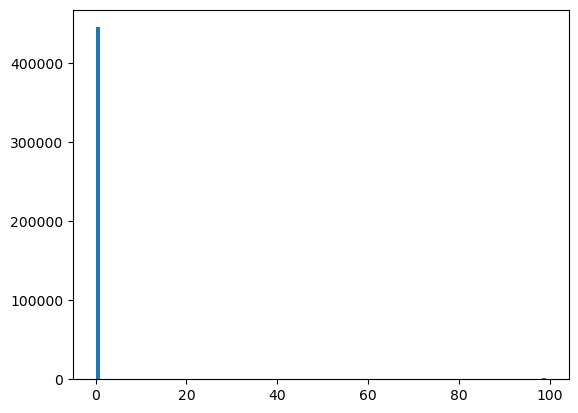

In [14]:
plt.hist(chassis_df['throttlePercentage'], bins=100)

In [15]:
control_df

,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,brake,...,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action,batch
0,0,0,pad,0,1669085612700316,0,0,0,0.000000,21.684950,...,0,COMPLETE_MANUAL,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,2,0.0
1,1,0,pad,0,1669085612800407,0,0,0,0.000000,18.193049,...,0,COMPLETE_MANUAL,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,2,0.0
2,2,0,pad,0,1669085612800407,0,0,0,0.000000,17.526353,...,0,COMPLETE_MANUAL,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,2,0.0
3,3,0,pad,0,1669085612800407,0,0,0,0.000000,18.642779,...,0,COMPLETE_MANUAL,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,2,0.0
4,4,0,pad,0,1669085612800407,0,0,0,0.000000,20.734509,...,0,COMPLETE_MANUAL,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461826,461826,0,pad,0,1669082163800178,0,0,0,9.896706,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
461827,461827,0,pad,0,1669082163800178,0,0,0,0.000000,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
461828,461828,0,pad,0,1669082163800178,0,0,0,0.000000,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
461829,461829,0,pad,0,1669082163800178,0,0,0,0.000000,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0


In [16]:
control_df.columns

Index(['Unnamed: 0', 'header_timestampSec', 'header_moduleName',
       'header_sequenceNum', 'header_lidarTimestamp', 'header_cameraTimestamp',
       'header_radarTimestamp', 'speedCmd', 'throttle', 'brake',
       'steeringRate', 'steeringTarget', 'parkingBrake', 'drivingMode',
       'gearLocation', 'isEstop', 'signal_turnSignal', 'signal_horn',
       'signal_emergencyLight', 'signal_beam', 'padMsg_action', 'batch'],
      dtype='object')

Index(['Unnamed: 0', 'header_timestampSec', 'header_moduleName',
       'header_sequenceNum', 'header_lidarTimestamp', 'header_cameraTimestamp',
       'header_radarTimestamp', 'speedCmd', 'throttle', 'brake',
       'steeringRate', 'steeringTarget', 'parkingBrake', 'drivingMode',
       'gearLocation', 'isEstop', 'signal_turnSignal', 'signal_horn',
       'signal_emergencyLight', 'signal_beam', 'padMsg_action', 'batch'],
      dtype='object')

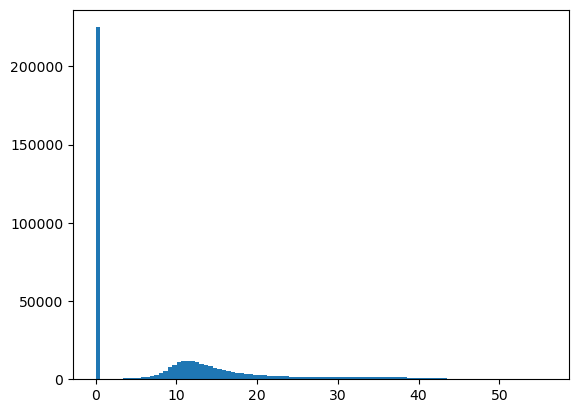

In [17]:
plt.hist(control_df['throttle'], bins=100)
control_df.columns

(array([3.23426e+05, 5.93300e+03, 5.22400e+03, 4.95800e+03, 5.16300e+03,
        5.47300e+03, 5.41200e+03, 5.41300e+03, 5.76200e+03, 5.10200e+03,
        4.71000e+03, 4.80000e+03, 4.58100e+03, 3.83600e+03, 3.52600e+03,
        3.03200e+03, 2.42500e+03, 2.02300e+03, 1.96700e+03, 1.89700e+03,
        1.33800e+03, 1.28900e+03, 1.03700e+03, 6.37000e+02, 4.91000e+02,
        4.50000e+02, 3.38000e+02, 3.20000e+02, 2.83000e+02, 1.95000e+02,
        2.68000e+02, 2.81000e+02, 1.34000e+02, 1.36000e+02, 1.30000e+02,
        1.19000e+02, 1.22000e+02, 1.13000e+02, 6.00000e+01, 6.00000e+01,
        3.60000e+01, 5.50000e+01, 5.50000e+01, 5.30000e+01, 2.80000e+01,
        3.70000e+01, 4.20000e+01, 4.30000e+01, 2.40000e+01, 4.00000e+01,
        3.40000e+01, 5.30000e+01, 5.40000e+01, 4.30000e+01, 2.90000e+01,
        4.70000e+01, 4.00000e+01, 3.30000e+01, 3.40000e+01, 3.00000e+01,
        4.80000e+01, 3.20000e+01, 3.20000e+01, 2.60000e+01, 4.20000e+01,
        4.20000e+01, 3.20000e+01, 4.40000e+01, 2.50

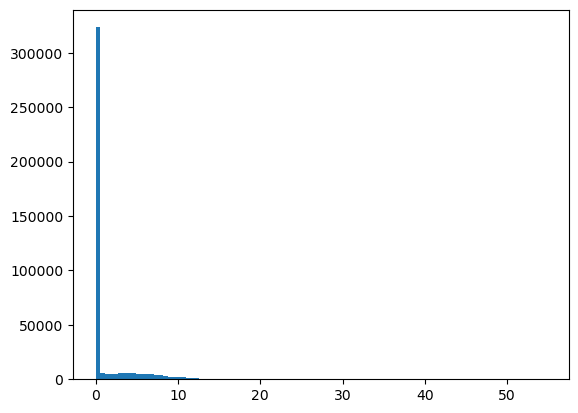

In [18]:
plt.hist(control_df[control_df["drivingMode"] == "COMPLETE_AUTO_DRIVE"]["brake"], bins=100)

Index(['Unnamed: 0', 'header_timestampSec', 'header_moduleName',
       'header_sequenceNum', 'header_lidarTimestamp', 'header_version',
       'position_x', 'position_y', 'position_z', 'orientation_qx',
       'orientation_qy', 'orientation_qz', 'orientation_qw',
       'linearVelocity_x', 'linearVelocity_y', 'linearVelocity_z',
       'linearAcceleration_x', 'linearAcceleration_y', 'linearAcceleration_z',
       'angularVelocity_x', 'angularVelocity_y', 'angularVelocity_z',
       'pose_heading', 'linearAccelerationVrf_x', 'linearAccelerationVrf_y',
       'linearAccelerationVrf_z', 'angularVelocityVrf_x',
       'angularVelocityVrf_y', 'angularVelocityVrf_z', 'linearVelocityVrf_x',
       'linearVelocityVrf_y', 'linearVelocityVrf_z', 'positionStdDev_x',
       'positionStdDev_y', 'positionStdDev_z', 'orientationStdDev_x',
       'orientationStdDev_y', 'orientationStdDev_z',
       'linearAccelerationStdDev_x', 'linearAccelerationStdDev_y',
       'linearAccelerationStdDev_z', 'measu

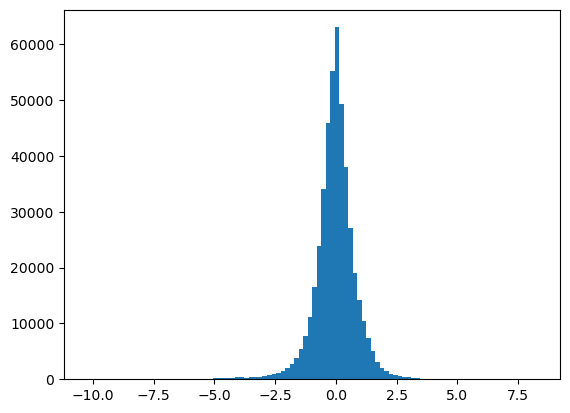

In [19]:
plt.hist(localization_df['linearAccelerationVrf_y'], bins=100)
localization_df.columns

In [20]:
chassis_features = ['engineRpm', 
                    'speedMps', 
                    'driveMotorTorqueNm']

control_features = ['throttle', 
                    'brake']

localization_features = ["linearVelocityVrf_y", 
                         "linearAccelerationVrf_y"]


In [21]:
chassis_df = chassis_df.reset_index(drop=True)
control_df = control_df.reset_index(drop=True)
localization_df = localization_df.reset_index(drop=True)

In [22]:
chassis_df_v, valid_index = RemoveUnwantedData(chassis_df)

In [23]:
print(chassis_df.shape)
print(control_df.shape)
print(localization_df.shape)

(461831, 28)
(461831, 22)
(461831, 48)


In [24]:
valid_index.shape

(461831,)

(array([4.8900e+02, 1.4300e+02, 8.2000e+01, 4.7000e+01, 4.6000e+01,
        3.1000e+01, 4.0000e+01, 3.7000e+01, 6.6000e+01, 5.9000e+01,
        4.9000e+01, 3.5000e+01, 4.3000e+01, 4.0000e+01, 1.2000e+02,
        8.1000e+01, 8.2000e+01, 1.5200e+02, 6.6600e+02, 8.8540e+03,
        9.7380e+03, 2.7580e+03, 2.1180e+03, 1.8970e+03, 1.7500e+03,
        1.6380e+03, 2.0080e+03, 2.0340e+03, 2.5270e+03, 5.0070e+03,
        3.7980e+03, 3.4550e+03, 4.1740e+03, 3.0280e+03, 3.3200e+03,
        3.8860e+03, 5.9720e+03, 3.9229e+04, 6.1790e+03, 3.5590e+03,
        4.1050e+03, 3.7900e+03, 4.7610e+03, 1.3881e+04, 1.0463e+04,
        6.3960e+03, 6.4480e+03, 1.3795e+04, 1.7838e+04, 1.3016e+04,
        9.6490e+03, 1.8209e+04, 1.3091e+04, 1.0178e+04, 1.1777e+04,
        1.1675e+04, 1.2436e+04, 1.4516e+04, 4.5115e+04, 3.1700e+03,
        5.1400e+02, 3.9600e+02, 3.8000e+02, 3.7600e+02, 4.1700e+02,
        4.9200e+02, 5.4700e+02, 7.0300e+02, 6.0500e+02, 5.9200e+02,
        6.6600e+02, 5.3400e+02, 5.2100e+02, 5.29

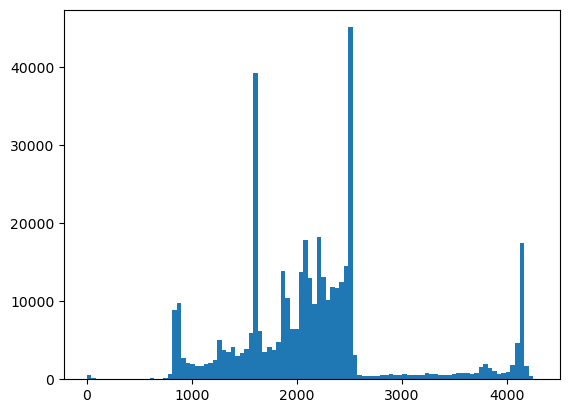

In [25]:
plt.hist(chassis_df_v['engineRpm'], bins=100)

In [26]:
chassis_df_v = chassis_df_v.reset_index()
control_df_v  = control_df[valid_index].reset_index()
localization_df_v = localization_df[valid_index].reset_index()

In [27]:
chassis_df_v

,index,Unnamed: 0,engineRpm,speedMps,fuelRangeM,throttlePercentage,brakePercentage,steeringPercentage,parkingBrake,highBeamSignal,...,realSteeringAngle,batterySoc,cmdDrivingMode,driveMotorTorqueNm,enableButton,disableButton,signal_turnSignal,batteryVoltage,batteryCurrent,batch
0,1063,1063,616.50,5.590048,1,0.0,0.0,-2.7250,False,False,...,-21.8,100,1.0,3,True,False,NaN,NaN,NaN,1.0
1,1064,1064,616.50,5.590048,1,0.0,0.0,-2.7125,False,False,...,-21.7,100,1.0,3,True,False,NaN,NaN,NaN,1.0
2,1065,1065,616.00,5.590048,1,0.0,0.0,-2.7125,False,False,...,-21.7,100,1.0,3,True,False,NaN,NaN,NaN,1.0
3,1066,1066,615.25,5.590048,1,0.0,0.0,-2.6750,False,False,...,-21.4,100,1.0,3,True,False,NaN,NaN,NaN,1.0
4,1067,1067,615.25,5.590048,1,0.0,0.0,-2.6750,False,False,...,-21.4,100,1.0,0,True,False,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414738,461826,461826,2514.00,21.959509,1,0.0,0.0,0.2125,False,False,...,1.7,100,1.0,22,False,False,TURN_NONE,NaN,NaN,498.0
414739,461827,461827,2514.25,21.959509,1,0.0,0.0,0.2125,False,False,...,1.7,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0
414740,461828,461828,2514.25,21.959509,1,0.0,0.0,0.2125,False,False,...,1.7,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0
414741,461829,461829,2514.50,21.948650,1,0.0,0.0,0.2000,False,False,...,1.6,100,1.0,25,False,False,TURN_NONE,NaN,NaN,498.0


In [28]:
control_df_v

,index,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,...,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action,batch
0,1063,1063,0,pad,0,1669085623401165,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,1.0
1,1064,1064,0,pad,0,1669085623401165,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,1.0
2,1065,1065,0,pad,0,1669085623401165,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,1.0
3,1066,1066,0,pad,0,1669085623401165,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,1.0
4,1067,1067,0,pad,0,1669085623401165,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414738,461826,461826,0,pad,0,1669082163800178,0,0,0,9.896706,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
414739,461827,461827,0,pad,0,1669082163800178,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
414740,461828,461828,0,pad,0,1669082163800178,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0
414741,461829,461829,0,pad,0,1669082163800178,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1,498.0


In [29]:
localization_df_v

,index,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_version,position_x,position_y,position_z,...,linearAccelerationStdDev_x,linearAccelerationStdDev_y,linearAccelerationStdDev_z,measurementTime,jerk_x,jerk_y,jerk_z,odom_heading,mode,batch
0,1063,1063,1.669086e+09,localization,248559,1669085623501057,0,-10663.899014,10183.377683,39.958398,...,0.036101,-0.276083,-0.810312,1.669086e+09,0.083220,-0.716208,-0.714548,1.595148,ABSOLUTE_MODE,1.0
1,1064,1064,1.669086e+09,localization,248560,1669085623501057,0,-10663.898820,10183.377756,39.958308,...,0.181271,-0.520900,-0.457124,1.669086e+09,-0.078664,-0.685785,-0.303099,1.594948,ABSOLUTE_MODE,1.0
2,1065,1065,1.669086e+09,localization,248561,1669085623501057,0,-10663.898840,10183.377627,39.958270,...,0.146924,-0.764178,-0.194385,1.669086e+09,-0.079620,-1.028956,-0.642908,1.594726,ABSOLUTE_MODE,1.0
3,1066,1066,1.669086e+09,localization,248562,1669085623501057,0,-10663.898692,10183.377775,39.958329,...,0.011101,-1.045967,-0.053998,1.669086e+09,-0.127802,-0.586942,-0.181133,1.594486,ABSOLUTE_MODE,1.0
4,1067,1067,1.669086e+09,localization,248563,1669085623501057,0,-10663.899081,10183.378488,39.959853,...,0.056263,-1.382648,0.545562,1.669086e+09,-0.190053,-0.369283,-0.143991,1.594239,ABSOLUTE_MODE,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414738,461826,461826,1.669082e+09,localization,113432,1669082163800178,0,2963.531520,-3668.651623,181.599416,...,0.188173,0.238550,0.946991,1.669082e+09,0.383320,0.874346,1.795794,0.971685,ABSOLUTE_MODE,498.0
414739,461827,461827,1.669082e+09,localization,113433,1669082163800178,0,2963.489742,-3668.665817,181.780702,...,0.107805,0.197873,1.483473,1.669082e+09,0.071217,0.068691,-1.018133,0.971707,ABSOLUTE_MODE,498.0
414740,461828,461828,1.669082e+09,localization,113434,1669082163800178,0,2963.410313,-3668.698031,181.740712,...,0.082097,0.375674,0.310825,1.669082e+09,-0.964899,0.439265,1.089503,0.971698,ABSOLUTE_MODE,498.0
414741,461829,461829,1.669082e+09,localization,113435,1669082163900263,0,2963.473243,-3668.681542,181.036558,...,-0.197210,0.472078,-0.277176,1.669082e+09,-0.936382,-0.464191,-1.672425,0.971667,ABSOLUTE_MODE,498.0


In [30]:
train_x_batch = pd.DataFrame()
train_y_batch = pd.DataFrame()

In [31]:
num_batches = chassis_df["batch"].unique().shape[0]

In [32]:
control_df_v[control_features[0]]

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
414738     9.896706
414739     0.000000
414740     0.000000
414741     0.000000
414742    10.731170
Name: throttle, Length: 414743, dtype: float64

In [33]:
control_df_v[control_features[1]].max()

54.76207115336667

In [34]:
for b in range(int(num_batches)):
    chassis_b = chassis_df_v[chassis_df_v["batch"] == b].reset_index(drop=True)
    localization_b = localization_df_v[localization_df_v["batch"] == b].reset_index(drop=True)
    control_b = control_df_v[control_df_v["batch"] == b].reset_index(drop=True)
    
    num_samples = chassis_b.shape[0] - 1
    
    train_x = pd.concat(
        [chassis_b.loc[0:num_samples-1, chassis_features].reset_index(drop=True), 
         localization_b.loc[0:num_samples-1, localization_features].reset_index(drop=True), 
         localization_b.loc[1:num_samples, localization_features].reset_index(drop=True)], 
        ignore_index=True,
        axis=1)
    
    train_x["batch"] = b

    train_y = pd.DataFrame(control_b.loc[0:num_samples-1, control_features[0]] - control_b.loc[0:num_samples-1, control_features[1]])
    
    train_y["batch"] = b
    print(train_y)
    
    
    train_x_batch = pd.concat([train_x_batch, train_x], axis=0, ignore_index=True)
    train_y_batch = pd.concat([train_y_batch, train_y], axis=0, ignore_index=True)    

Empty DataFrame
Columns: [0, batch]
Index: []
             0  batch
0     0.000000      1
1     0.000000      1
2     0.000000      1
3     0.000000      1
4     0.000000      1
..         ...    ...
931  40.189798      1
932  42.037074      1
933  40.893773      1
934  42.631745      1
935  40.704270      1

[936 rows x 2 columns]
             0  batch
0    40.631769      2
1    42.165771      2
2    41.921392      2
3    42.441318      2
4    41.310318      2
..         ...    ...
994  31.815558      2
995  31.886497      2
996  31.453846      2
997  32.017362      2
998  31.244817      2

[999 rows x 2 columns]
             0  batch
0    31.311338      3
1    30.902459      3
2    31.742705      3
3    31.653321      3
4    31.840811      3
..         ...    ...
994  -8.585155      3
995  -6.463546      3
996  -8.265524      3
997  -5.964008      3
998  -5.819765      3

[999 rows x 2 columns]
             0  batch
0    -5.598457      4
1    -6.207778      4
2    -5.369410      4
3 

             0  batch
0     0.000000     38
1     0.000000     38
2     0.000000     38
3     0.000000     38
4     0.000000     38
..         ...    ...
994  11.191681     38
995  11.215568     38
996  11.214668     38
997  11.299903     38
998  11.370420     38

[999 rows x 2 columns]
             0  batch
0    11.471645     39
1    11.421474     39
2    11.429354     39
3     0.000000     39
4    11.451938     39
..         ...    ...
994  10.524480     39
995  10.459097     39
996   0.000000     39
997  10.426100     39
998  10.422864     39

[999 rows x 2 columns]
             0  batch
0    10.404927     40
1    10.386970     40
2     0.000000     40
3     0.000000     40
4     0.000000     40
..         ...    ...
994  14.170038     40
995  14.543401     40
996  14.179937     40
997  15.509602     40
998  13.829906     40

[999 rows x 2 columns]
             0  batch
0    14.060672     41
1    12.535348     41
2    15.523440     41
3    12.221036     41
4    14.865945     41
..  

             0  batch
0   -44.931851     73
1   -43.392727     73
2   -45.934574     73
3   -44.165702     73
4   -45.383312     73
..         ...    ...
994 -11.598610     73
995 -11.606293     73
996 -11.638796     73
997 -11.640895     73
998 -11.666840     73

[999 rows x 2 columns]
             0  batch
0   -11.683660     74
1   -11.699659     74
2   -11.766477     74
3   -11.796107     74
4   -11.802471     74
..         ...    ...
994  -7.510147     74
995  -8.860381     74
996  -7.619826     74
997  -8.479078     74
998  -7.837914     74

[999 rows x 2 columns]
            0  batch
0   -9.174038     75
1   -9.236761     75
2   -8.293268     75
3   -9.453816     75
4   -9.609127     75
..        ...    ...
294 -6.437338     75
295 -8.775533     75
296 -6.290625     75
297 -8.735531     75
298 -6.452114     75

[299 rows x 2 columns]
            0  batch
0   -3.407417     76
1   -3.496219     76
2   -0.593271     76
3   -3.172918     76
4   -0.102010     76
..        ...    ...
9

            0  batch
0    0.000000    107
1    0.000000    107
2    0.000000    107
3    0.000000    107
4    0.000000    107
..        ...    ...
994  0.000000    107
995  0.000000    107
996  8.303821    107
997  8.399176    107
998  0.000000    107

[999 rows x 2 columns]
             0  batch
0     8.509062    108
1     0.000000    108
2     0.000000    108
3     0.000000    108
4     0.000000    108
..         ...    ...
994  12.060259    108
995  12.158885    108
996  12.150956    108
997  12.187696    108
998  12.288710    108

[999 rows x 2 columns]
             0  batch
0    12.139568    109
1    14.113535    109
2    12.397376    109
3    11.941486    109
4    11.485627    109
..         ...    ...
594   0.000000    109
595   0.000000    109
596   0.000000    109
597   0.000000    109
598   0.000000    109

[599 rows x 2 columns]
             0  batch
0    26.206566    110
1    19.443534    110
2    26.711895    110
3    18.479182    110
4    16.636741    110
..         ...  

             0  batch
0   -10.592230    141
1   -10.790079    141
2   -10.873617    141
3   -11.013836    141
4   -10.866078    141
..         ...    ...
994   6.983348    141
995   6.969063    141
996   6.958872    141
997   6.952784    141
998   6.953376    141

[999 rows x 2 columns]
             0  batch
0     6.992161    142
1     7.026905    142
2     7.067910    142
3     7.097907    142
4     7.133824    142
..         ...    ...
994  46.110937    142
995  46.104928    142
996  46.193277    142
997  46.309517    142
998  45.028128    142

[999 rows x 2 columns]
             0  batch
0    45.036583    143
1    45.141565    143
2    45.254163    143
3    45.718544    143
4    45.761964    143
..         ...    ...
994  12.714320    143
995  11.354440    143
996  11.723827    143
997  12.123024    143
998  12.304238    143

[999 rows x 2 columns]
             0  batch
0    12.547723    144
1    12.702079    144
2    13.147324    144
3    14.252612    144
4    14.770728    144
..  

             0  batch
0     8.997255    174
1     0.000000    174
2     0.000000    174
3     0.000000    174
4     0.000000    174
..         ...    ...
994  14.546242    174
995  12.092432    174
996  14.029906    174
997  12.632353    174
998  12.435039    174

[999 rows x 2 columns]
             0  batch
0    11.102504    175
1    12.130269    175
2    11.241615    175
3    11.524631    175
4    11.049015    175
..         ...    ...
994   0.000000    175
995   0.000000    175
996   9.976271    175
997   0.000000    175
998  10.308739    175

[999 rows x 2 columns]
             0  batch
0     0.000000    176
1    10.394121    176
2     0.000000    176
3    12.335664    176
4     0.000000    176
..         ...    ...
994   0.000000    176
995   9.249192    176
996   0.000000    176
997   0.000000    176
998   0.000000    176

[999 rows x 2 columns]
             0  batch
0     0.000000    177
1     0.000000    177
2     0.000000    177
3     0.000000    177
4     0.000000    177
..  

             0  batch
0    -8.117874    239
1    -5.258340    239
2    -8.123628    239
3    -5.783316    239
4    -7.301476    239
..         ...    ...
994  13.238038    239
995  13.149067    239
996  13.993235    239
997  12.856474    239
998  14.728926    239

[999 rows x 2 columns]
             0  batch
0    14.962099    240
1    13.908796    240
2    13.922549    240
3    14.583337    240
4    13.214048    240
..         ...    ...
994  39.340122    240
995  39.054730    240
996  40.212562    240
997  38.944896    240
998  41.004300    240

[999 rows x 2 columns]
             0  batch
0    41.648639    241
1    41.060811    241
2    39.835738    241
3    41.260463    241
4    40.511903    241
..         ...    ...
994  -3.041336    241
995  -3.721992    241
996  -3.030795    241
997  -3.809287    241
998  -3.279774    241

[999 rows x 2 columns]
             0  batch
0    -3.483156    242
1    -2.901794    242
2    -3.493339    242
3    -3.276604    242
4    -3.497112    242
..  

             0  batch
0   -44.931851    303
1   -43.392727    303
2   -45.934574    303
3   -44.165702    303
4   -45.383312    303
..         ...    ...
994 -11.598610    303
995 -11.606293    303
996 -11.638796    303
997 -11.640895    303
998 -11.666840    303

[999 rows x 2 columns]
             0  batch
0   -11.683660    304
1   -11.699659    304
2   -11.766477    304
3   -11.796107    304
4   -11.802471    304
..         ...    ...
494  -7.223219    304
495  -7.659239    304
496  -7.899303    304
497  -7.460969    304
498  -8.243063    304

[499 rows x 2 columns]
             0  batch
0    44.022530    305
1    42.166621    305
2    42.755963    305
3    43.769481    305
4    43.725876    305
..         ...    ...
994  -7.500403    305
995  -7.313773    305
996  -7.735262    305
997  -8.803615    305
998  -7.863201    305

[999 rows x 2 columns]
             0  batch
0    -8.973381    306
1    -8.848604    306
2    -8.593586    306
3    -9.205754    306
4    -8.723513    306
..  

            0  batch
0    7.653162    365
1    0.000000    365
2    8.461705    365
3    0.000000    365
4    0.000000    365
..        ...    ...
994  0.000000    365
995  0.000000    365
996  5.862512    365
997  0.000000    365
998  6.541759    365

[999 rows x 2 columns]
            0  batch
0    7.132000    366
1    0.000000    366
2    0.000000    366
3    8.355189    366
4    0.000000    366
..        ...    ...
994 -5.925904    366
995 -6.197107    366
996 -6.133684    366
997 -5.766674    366
998 -6.539804    366

[999 rows x 2 columns]
            0  batch
0   -6.379752    367
1   -5.196402    367
2   -6.281745    367
3   -5.737068    367
4   -5.900477    367
..        ...    ...
994  0.000000    367
995  0.000000    367
996  0.000000    367
997  0.000000    367
998  0.000000    367

[999 rows x 2 columns]
             0  batch
0     0.000000    368
1     0.000000    368
2     0.000000    368
3     0.000000    368
4     0.000000    368
..         ...    ...
994  15.034566    

             0  batch
0    15.476213    423
1    15.354437    423
2    13.871757    423
3    15.331375    423
4     0.000000    423
..         ...    ...
994   0.000000    423
995   0.000000    423
996   0.000000    423
997   0.000000    423
998   0.000000    423

[999 rows x 2 columns]
             0  batch
0     0.000000    424
1     9.417421    424
2     0.000000    424
3     0.000000    424
4     0.000000    424
..         ...    ...
994  12.625410    424
995   0.000000    424
996  10.229194    424
997   0.000000    424
998   0.000000    424

[999 rows x 2 columns]
             0  batch
0     0.000000    425
1     8.924336    425
2     0.000000    425
3     0.000000    425
4     0.000000    425
..         ...    ...
994   8.392496    425
995   0.000000    425
996  10.429247    425
997   0.000000    425
998   9.245039    425

[999 rows x 2 columns]
             0  batch
0     0.000000    426
1    10.219046    426
2     0.000000    426
3    11.314306    426
4     0.000000    426
..  

             0  batch
0    40.137832    479
1    39.584159    479
2    41.445430    479
3    39.672517    479
4    41.178171    479
..         ...    ...
994  -6.502833    479
995  -6.825133    479
996  -6.846517    479
997  -6.898979    479
998  -6.930434    479

[999 rows x 2 columns]
            0  batch
0   -6.635194    480
1   -7.112025    480
2   -6.853341    480
3   -7.167327    480
4   -7.240901    480
..        ...    ...
994  0.000000    480
995  0.000000    480
996  0.000000    480
997  0.000000    480
998  0.000000    480

[999 rows x 2 columns]
             0  batch
0     0.000000    481
1     9.997157    481
2     0.000000    481
3     9.806143    481
4     9.202884    481
..         ...    ...
994  18.903445    481
995  18.976121    481
996  16.517008    481
997  19.110909    481
998  17.368056    481

[999 rows x 2 columns]
             0  batch
0    18.361433    482
1    19.165456    482
2    19.925537    482
3    19.034375    482
4    20.457455    482
..         ...  

In [35]:
train_x_batch

,0,1,2,3,4,5,6,batch
0,616.50,5.590048,3,5.346133,-0.033065,5.341251,-0.158215,1
1,616.50,5.590048,3,5.341251,-0.158215,5.343745,-0.285064,1
2,616.00,5.590048,3,5.343745,-0.285064,5.348937,-0.433516,1
3,615.25,5.590048,3,5.348937,-0.433516,5.349001,-0.612163,1
4,615.25,5.590048,0,5.349001,-0.612163,5.342610,-0.655759,1
...,...,...,...,...,...,...,...,...
414277,2513.50,21.959509,22,21.655508,0.324616,21.656412,0.092815,498
414278,2514.00,21.959509,22,21.656412,0.092815,21.649312,0.074804,498
414279,2514.25,21.959509,25,21.649312,0.074804,21.644914,0.165990,498
414280,2514.25,21.959509,25,21.644914,0.165990,21.645177,0.218396,498


In [36]:
train_y_batch.min()

0       -54.762071
batch     1.000000
dtype: float64

In [37]:
x_shifter = np.array([0.000000, 0.000000, -70.000000, -0.3, -5, -0.3, -5])
x_normalizer = np.array([4300.0, 24.0, 255.000000, 22.5, 10, 22.5, 10])

y_shifter = np.array([-60])
y_normalizer = np.array([120])

In [38]:
train_x_n, x_shifter, x_normalizer = NormalizeData(train_x_batch, x_shifter, x_normalizer)
train_y_n, y_shifter, y_normalizer = NormalizeData(train_y_batch, y_shifter, y_normalizer)

In [39]:
y_shifter

array([-60])

In [40]:
y_normalizer

array([120])

(array([3676., 2500., 4995., 4995., 4295., 4995., 3757., 3996., 4395.,
        3283., 4995., 2849., 4104., 4995., 3395., 4995., 2496., 4995.,
        3753., 4995., 4095., 4595., 4995., 4195., 4595., 4195., 4826.,
        2172., 4995., 4995., 4095., 4995., 4095., 3996., 4995., 4095.,
        2416., 3396., 2757., 4995., 3040., 3667., 4995., 4995., 3304.,
        2997., 4995., 4995., 3253., 3696., 2248., 4995., 4795., 2451.,
        3804., 4086., 4995., 1994., 4995., 4395., 3795., 2674., 2521.,
        4995., 1247., 4227., 3496., 4995., 4795., 4395., 4146., 2997.,
        4895., 4995., 4995., 4095., 4395., 4995., 3651., 4995., 4995.,
        4095., 2467., 4949., 4295., 4995., 4995., 4095., 4495., 4995.,
        4995., 4195., 4395., 3814., 3996., 4995., 4095., 4478., 4695.,
        4302.]),
 array([  1.  ,   5.97,  10.94,  15.91,  20.88,  25.85,  30.82,  35.79,
         40.76,  45.73,  50.7 ,  55.67,  60.64,  65.61,  70.58,  75.55,
         80.52,  85.49,  90.46,  95.43, 100.4 , 105.37, 11

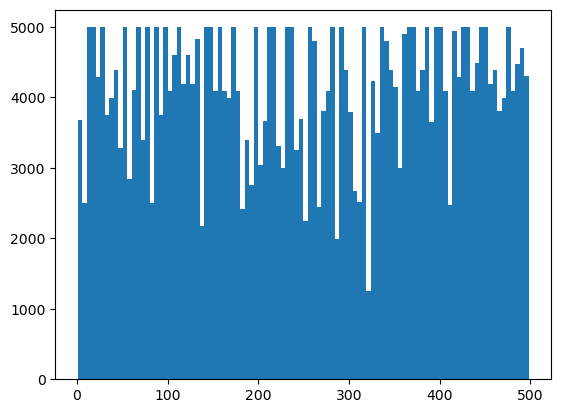

In [41]:
plt.hist(train_x_n["batch"], bins=100)

In [42]:
train_x_n.columns

Index([0, 1, 2, 3, 4, 5, 6, 'batch'], dtype='object')

In [43]:
train_y_n[train_y_n["batch"]==4].shape

(377, 2)

In [44]:
if len(train_y_n.shape) == 1:
    train_y_n = train_y_n.reshape(train_y_n.shape[0], -1)

(array([4.5600e+02, 4.0000e+01, 4.3000e+01, 7.8000e+01, 7.1000e+01,
        7.4000e+01, 6.1000e+01, 9.0000e+01, 8.6000e+01, 9.1000e+01,
        8.8000e+01, 7.7000e+01, 1.0000e+02, 9.0000e+01, 7.1000e+01,
        8.7000e+01, 1.0500e+02, 8.9000e+01, 1.1600e+02, 1.3600e+02,
        1.5200e+02, 1.9000e+02, 2.1300e+02, 2.3500e+02, 3.2000e+02,
        3.1700e+02, 3.8300e+02, 5.2800e+02, 5.1700e+02, 6.8900e+02,
        8.6500e+02, 1.0190e+03, 1.2750e+03, 1.4990e+03, 1.8230e+03,
        2.3550e+03, 2.8830e+03, 3.6200e+03, 4.2970e+03, 5.4380e+03,
        6.8310e+03, 8.6000e+03, 1.0515e+04, 1.2769e+04, 1.6025e+04,
        1.8952e+04, 2.2474e+04, 2.5448e+04, 2.7401e+04, 2.8582e+04,
        2.8252e+04, 2.6705e+04, 2.3927e+04, 2.1000e+04, 1.8131e+04,
        1.4844e+04, 1.2595e+04, 1.0185e+04, 8.6960e+03, 7.5790e+03,
        6.0890e+03, 5.3080e+03, 4.4730e+03, 3.5390e+03, 3.0100e+03,
        2.4270e+03, 1.7940e+03, 1.4090e+03, 1.1080e+03, 8.8800e+02,
        7.0400e+02, 6.0400e+02, 4.4700e+02, 3.61

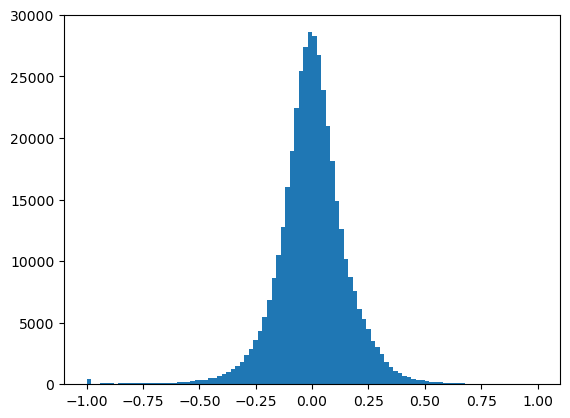

In [45]:
plt.hist(train_x_n[6], bins=100)

(array([1.0500e+02, 4.3000e+01, 3.3000e+01, 1.9000e+01, 3.6000e+01,
        5.4000e+01, 3.8000e+01, 1.3900e+02, 7.8000e+01, 6.8000e+01,
        5.7000e+01, 6.5000e+01, 1.7300e+02, 1.1600e+02, 1.2800e+02,
        5.7000e+01, 8.4000e+01, 7.9000e+01, 5.9000e+01, 7.9000e+01,
        6.5000e+01, 7.6000e+01, 7.6000e+01, 1.0800e+02, 7.4000e+01,
        6.9000e+01, 8.1000e+01, 7.1000e+01, 1.1500e+02, 9.7000e+01,
        1.5300e+02, 2.5000e+02, 2.4800e+02, 3.3900e+02, 5.4400e+02,
        5.3400e+02, 7.9800e+02, 1.0370e+03, 2.1820e+03, 3.0890e+03,
        3.9950e+03, 5.3100e+03, 7.3400e+03, 9.2540e+03, 9.7850e+03,
        1.1363e+04, 1.0918e+04, 1.0232e+04, 1.1237e+04, 9.8351e+04,
        2.4600e+02, 3.4800e+02, 8.0400e+02, 1.5890e+03, 2.1440e+03,
        3.4040e+03, 6.4430e+03, 1.2122e+04, 1.9479e+04, 2.2754e+04,
        2.2037e+04, 1.8746e+04, 1.5496e+04, 1.1648e+04, 8.7790e+03,
        6.9260e+03, 5.5430e+03, 4.6310e+03, 4.0730e+03, 3.6840e+03,
        3.5150e+03, 3.2410e+03, 3.3010e+03, 3.06

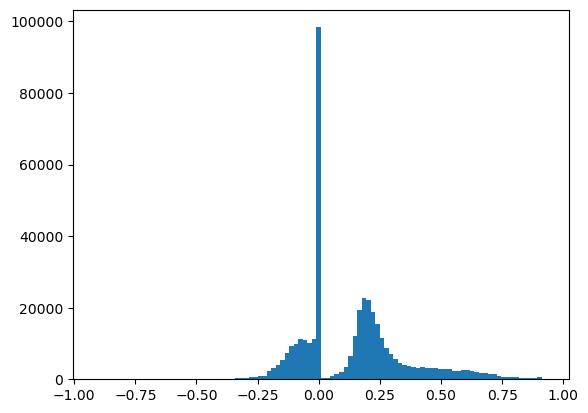

In [46]:
plt.hist(train_y_n[0], bins=100)

In [47]:
# num_latents = 100
# latent_features = 8
# num_tasks = 1 if len(train_y_n.shape) == 1 else train_y_n.shape[1]

# class MultitaskGPModel(gpytorch.models.ApproximateGP):
#     def __init__(self):
#         # Let's use a different set of inducing points for each latent function
#         inducing_points = torch.rand(num_latents, latent_features, train_x_n.shape[1] - 1)

#         # We have to mark the CholeskyVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
#         variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([num_latents])
#         )

#         # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
#         # so that the output will be a MultitaskMultivariateNormal rather than a batch output
#         variational_strategy = gpytorch.variational.LMCVariationalStrategy(
#             gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, variational_distribution, learn_inducing_locations=True
#             ),
#             num_tasks=num_tasks,
#             num_latents=num_latents,
#             latent_dim=-1
#         )

#         super().__init__(variational_strategy)

#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
#             batch_shape=torch.Size([num_latents])
#         )

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [48]:
# model = MultitaskGPModel().cuda()
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).cuda()

In [49]:
# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.base_covar_module = RBFKernel()
#         self.covar_module = ProductStructureKernel(
#             ScaleKernel(
#                 GridInterpolationKernel(self.base_covar_module, grid_size=100, num_dims=1)
#             ), num_dims=18
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [51]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.randn(128, train_x.shape[-1] - 1, dtype=torch.float).to(device)

model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()

In [52]:
train_y_n.shape[0]

414282

In [53]:
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 300


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)


scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_n.shape[0])
# mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=1000)


writer = SummaryWriter()


# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    
    optimizer.zero_grad()
    
    start_index = 0
    
    losses = []
    

    for b in range(int(num_batches)):
        batch = torch.tensor(train_x_n[train_x_n["batch"]==b].filter(items=[0, 1, 2, 3, 4, 5, 6]).to_numpy(), dtype=torch.float, requires_grad=False).to(device)
        
        if batch.shape[0] == 0:
            continue
        target = torch.tensor(train_y_n[train_y_n["batch"]==b].filter(items=[0]).to_numpy(), dtype=torch.float).to(device)
        output = model(batch)
        loss = -mll(output, target.flatten())
        loss.backward()
        losses.append(loss.item())
    
    total_loss = sum(losses)
    
    epochs_iter.set_postfix(loss=total_loss)
    writer.add_scalar('Loss/train', total_loss, i)
    optimizer.step()
    scheduler.step()
    torch.cuda.empty_cache()
    
writer.close()

Epoch: 100%|███████████████████████████████████████████| 300/300 [29:49<00:00,  5.96s/it, loss=-412]


In [54]:
torch.save(model.state_dict(), 'longitudinal_dynamics_svgp.pth')
torch.save(likelihood.state_dict(), 'longitudinal_dynamics_likelihood.pth')

In [55]:
chassis_df_t = pd.DataFrame()
control_df_t = pd.DataFrame()
localization_df_t = pd.DataFrame()

In [56]:
senario_id = 5798516384428

In [57]:
tmp1 = []
tmp2 = []
tmp3 = []

with open(f"/home/{username}/workspace/dataset_downloader/{task}/processed/{senario_id}/env_learning_zip/chassis.txt") as file:
    for line in file:
        tmp1.append(flatten_dict(json.loads(line)))
        

with open(f"/home/{username}/workspace/dataset_downloader/{task}/processed/{senario_id}/env_learning_zip/control.txt") as file:
    for line in file:
        tmp2.append(flatten_dict(json.loads(line)))
        
with open(f"/home/{username}/workspace/dataset_downloader/{task}/processed/{senario_id}/env_learning_zip/localization.txt") as file:
    for line in file:
        tmp3.append(flatten_dict(json.loads(line)))

chassis_df_t = pd.DataFrame(tmp1)
control_df_t = pd.DataFrame(tmp2)
localization_df_t = pd.DataFrame(tmp3)

Index(['header_timestampSec', 'header_moduleName', 'header_sequenceNum',
       'header_lidarTimestamp', 'header_cameraTimestamp',
       'header_radarTimestamp', 'speedCmd', 'throttle', 'brake',
       'steeringRate', 'steeringTarget', 'parkingBrake', 'drivingMode',
       'gearLocation', 'isEstop', 'signal_turnSignal', 'signal_horn',
       'signal_emergencyLight', 'signal_beam', 'padMsg_action'],
      dtype='object')

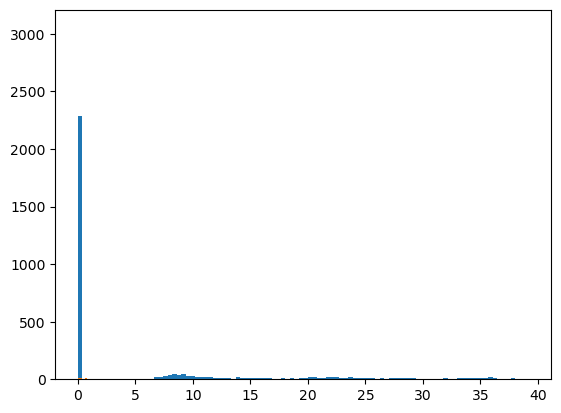

In [58]:
plt.hist(control_df_t['throttle'], bins=100)
plt.hist(control_df_t['brake'], bins=100)
control_df_t.columns

Index(['header_timestampSec', 'header_moduleName', 'header_sequenceNum',
       'header_lidarTimestamp', 'header_version', 'position_x', 'position_y',
       'position_z', 'orientation_qx', 'orientation_qy', 'orientation_qz',
       'orientation_qw', 'linearVelocity_x', 'linearVelocity_y',
       'linearVelocity_z', 'linearAcceleration_x', 'linearAcceleration_y',
       'linearAcceleration_z', 'angularVelocity_x', 'angularVelocity_y',
       'angularVelocity_z', 'pose_heading', 'linearAccelerationVrf_x',
       'linearAccelerationVrf_y', 'linearAccelerationVrf_z',
       'angularVelocityVrf_x', 'angularVelocityVrf_y', 'angularVelocityVrf_z',
       'linearVelocityVrf_x', 'linearVelocityVrf_y', 'linearVelocityVrf_z',
       'positionStdDev_x', 'positionStdDev_y', 'positionStdDev_z',
       'orientationStdDev_x', 'orientationStdDev_y', 'orientationStdDev_z',
       'linearAccelerationStdDev_x', 'linearAccelerationStdDev_y',
       'linearAccelerationStdDev_z', 'measurementTime', 'jerk_x'

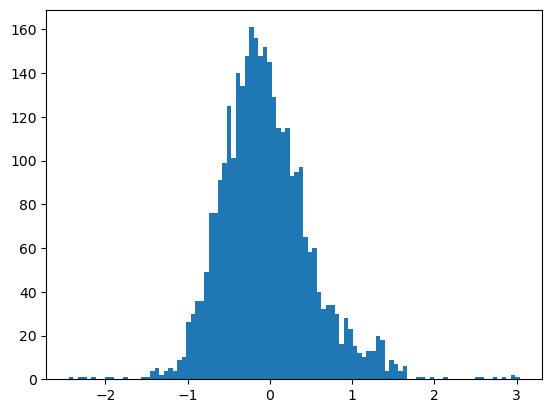

In [59]:
plt.hist(localization_df_t['linearAccelerationVrf_y'], bins=100)
localization_df_t.columns

In [60]:
chassis_df_t_v, valid_index_t = RemoveUnwantedData(chassis_df_t)

In [61]:
chassis_df_t_v = chassis_df_t_v.reset_index(drop=True)
control_df_t_v = control_df_t[valid_index_t].reset_index(drop=True)
localization_df_t_v = localization_df_t[valid_index_t].reset_index(drop=True)

In [62]:
chassis_df_t_v

,engineRpm,speedMps,fuelRangeM,throttlePercentage,brakePercentage,steeringPercentage,parkingBrake,highBeamSignal,drivingMode,errorCode,...,signal_horn,linearAccelerationVrf_x,linearAccelerationVrf_y,angularVelocityVrf_z,realSteeringAngle,batterySoc,cmdDrivingMode,driveMotorTorqueNm,enableButton,disableButton
0,2125.75,18.605263,1,0,0,-0.0500,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.320376,-0.3,0,-0.4,100,1.0,0,True,False
1,2125.00,18.582459,1,0,0,-0.0625,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.320376,-0.3,0,-0.5,100,1.0,0,True,False
2,2124.75,18.582459,1,0,0,-0.0625,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.330624,-0.3,0,-0.5,100,1.0,0,True,False
3,2124.00,18.582459,1,0,0,-0.0625,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.330624,-0.3,0,-0.5,100,1.0,0,True,False
4,2123.25,18.582459,1,0,0,-0.0875,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.330624,-0.3,0,-0.7,100,1.0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2497.25,21.838978,1,0,0,-0.2250,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.280360,0.0,0,-1.8,100,1.0,22,False,False
2178,2497.50,21.838978,1,0,0,-0.2250,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.270600,0.0,0,-1.8,100,1.0,22,False,False
2179,2497.50,21.838978,1,0,0,-0.2375,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.260352,0.0,0,-1.9,100,1.0,22,False,False
2180,2497.50,21.838978,1,0,0,-0.2375,False,False,COMPLETE_AUTO_DRIVE,NO_ERROR,...,False,0.260352,0.0,0,-1.9,100,1.0,22,False,False


In [63]:
control_df_t_v

,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,brake,steeringRate,steeringTarget,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action
0,0,pad,0,1669082543000413,0,0,0,14.180570,0.0,499.619197,-0.010594,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
1,0,pad,0,1669082543000413,0,0,0,15.667013,0.0,499.619197,-0.021498,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
2,0,pad,0,1669082543000413,0,0,0,13.931511,0.0,499.619197,-0.030868,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
3,0,pad,0,1669082543000413,0,0,0,13.895643,0.0,499.619197,-0.037093,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
4,0,pad,0,1669082543100415,0,0,0,18.271162,0.0,499.619197,-0.039898,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0,pad,0,1669082564800027,0,0,0,0.000000,0.0,499.619197,-0.293588,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
2178,0,pad,0,1669082564800027,0,0,0,0.000000,0.0,499.619197,-0.292623,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
2179,0,pad,0,1669082564800027,0,0,0,0.000000,0.0,499.619197,-0.296154,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
2180,0,pad,0,1669082564800027,0,0,0,0.000000,0.0,499.619197,-0.302882,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1


In [64]:
localization_df_t_v

,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_version,position_x,position_y,position_z,orientation_qx,orientation_qy,...,orientationStdDev_z,linearAccelerationStdDev_x,linearAccelerationStdDev_y,linearAccelerationStdDev_z,measurementTime,jerk_x,jerk_y,jerk_z,odom_heading,mode
0,1.669083e+09,localization,151355,1669082543000413,0,2804.667074,-3749.863127,-223.513142,0.002368,-0.008279,...,0.003447,-0.021432,0.047046,-0.028338,1.669083e+09,0.163204,-0.016241,1.196987,-2.047970,ABSOLUTE_MODE
1,1.669083e+09,localization,151356,1669082543000413,0,2804.671805,-3749.858913,-223.669288,0.002373,-0.008280,...,0.003480,-0.140787,0.240325,-0.984734,1.669083e+09,0.162438,-0.150189,-0.422590,-2.048008,ABSOLUTE_MODE
2,1.669083e+09,localization,151357,1669082543100415,0,2804.671374,-3749.859067,-223.668534,0.002373,-0.008280,...,0.003480,-0.057541,0.210908,-1.317527,1.669083e+09,0.162438,-0.150189,-0.422590,-2.048041,ABSOLUTE_MODE
3,1.669083e+09,localization,151358,1669082543100415,0,2804.678110,-3749.854002,-223.823479,0.002378,-0.008280,...,0.003480,0.066285,-0.258305,-0.135542,1.669083e+09,-0.265346,0.041428,0.463662,-2.048076,ABSOLUTE_MODE
4,1.669083e+09,localization,151359,1669082543100415,0,2804.689371,-3749.848321,-223.881310,0.002380,-0.008280,...,0.003532,0.091504,-0.339600,0.811483,1.669083e+09,-0.000583,0.100385,-1.926100,-2.048116,ABSOLUTE_MODE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,1.669083e+09,localization,153532,1669082564800027,0,2759.422545,-3768.973440,-197.578287,0.001598,-0.008085,...,0.003376,0.188993,0.825384,-0.103449,1.669083e+09,-0.036695,-0.059685,3.537024,-2.127048,ABSOLUTE_MODE
2178,1.669083e+09,localization,153533,1669082564800027,0,2759.421879,-3768.973046,-197.631787,0.001600,-0.008084,...,0.003410,0.450692,0.476225,0.304881,1.669083e+09,-0.496200,-0.029892,2.146863,-2.127105,ABSOLUTE_MODE
2179,1.669083e+09,localization,153534,1669082564800027,0,2759.415403,-3768.977903,-197.437383,0.001591,-0.008089,...,0.003410,0.382143,0.263369,0.073528,1.669083e+09,-0.687740,-0.274025,0.904410,-2.127138,ABSOLUTE_MODE
2180,1.669083e+09,localization,153535,1669082564900072,0,2759.420611,-3768.975682,-197.447680,0.001590,-0.008091,...,0.003444,0.268713,0.466098,0.002834,1.669083e+09,-0.492891,-0.025363,0.216473,-2.127160,ABSOLUTE_MODE


In [65]:
num_samples_t = chassis_df_t_v.shape[0] - 1

In [66]:
localization_df_t_v.loc[0:num_samples_t-1, localization_features]

,linearVelocityVrf_y,linearAccelerationVrf_y
0,18.273877,-0.289124
1,18.258044,-0.191896
2,18.255502,-0.204144
3,18.263995,-0.436994
4,18.270967,-0.480463
...,...,...
2176,21.495856,0.610601
2177,21.500638,0.444929
2178,21.503823,0.278442
2179,21.497878,0.177018


In [67]:
test_x = pd.concat(
    [chassis_df_t_v.loc[0:(num_samples_t-1), chassis_features].reset_index(drop=True), 
     localization_df_t_v.loc[0:(num_samples_t-1), localization_features].reset_index(drop=True), 
     localization_df_t_v.loc[1:num_samples_t, localization_features].reset_index(drop=True)], 
    ignore_index=True,
    axis=1)

test_y = control_df_t_v.loc[0:num_samples_t-1, control_features[0]] - control_df_t_v.loc[0:num_samples_t-1, control_features[1]]

In [68]:
print(test_x)

            0          1   2          3         4          5         6
0     2125.75  18.605263   0  18.273877 -0.289124  18.258044 -0.191896
1     2125.00  18.582459   0  18.258044 -0.191896  18.255502 -0.204144
2     2124.75  18.582459   0  18.255502 -0.204144  18.263995 -0.436994
3     2124.00  18.582459   0  18.263995 -0.436994  18.270967 -0.480463
4     2123.25  18.582459   0  18.270967 -0.480463  18.269832 -0.480618
...       ...        ...  ..        ...       ...        ...       ...
2176  2497.25  21.838978  22  21.495856  0.610601  21.500638  0.444929
2177  2497.25  21.838978  22  21.500638  0.444929  21.503823  0.278442
2178  2497.50  21.838978  22  21.503823  0.278442  21.497878  0.177018
2179  2497.50  21.838978  22  21.497878  0.177018  21.486241  0.281074
2180  2497.50  21.838978  22  21.486241  0.281074  21.479775  0.445150

[2181 rows x 7 columns]


In [69]:
print(chassis_df_t_v.iloc[1500:2500]["header_timestampSec"])

1500    1.669083e+09
1501    1.669083e+09
1502    1.669083e+09
1503    1.669083e+09
1504    1.669083e+09
            ...     
2177    1.669083e+09
2178    1.669083e+09
2179    1.669083e+09
2180    1.669083e+09
2181    1.669083e+09
Name: header_timestampSec, Length: 682, dtype: float64


In [70]:
test_x_n, _, _ = NormalizeData(test_x, x_shifter, x_normalizer, has_batch=False)
test_y_n, _, _ = NormalizeData(test_y, y_shifter, y_normalizer, has_batch=False)

In [71]:
test_x_n

,0,1,2,3,4,5,6
0,-0.011279,0.550439,-0.450980,0.651011,-0.057825,0.649604,-0.038379
1,-0.011628,0.548538,-0.450980,0.649604,-0.038379,0.649378,-0.040829
2,-0.011744,0.548538,-0.450980,0.649378,-0.040829,0.650133,-0.087399
3,-0.012093,0.548538,-0.450980,0.650133,-0.087399,0.650753,-0.096093
4,-0.012442,0.548538,-0.450980,0.650753,-0.096093,0.650652,-0.096124
...,...,...,...,...,...,...,...
2176,0.161512,0.819915,-0.278431,0.937409,0.122120,0.937834,0.088986
2177,0.161512,0.819915,-0.278431,0.937834,0.088986,0.938118,0.055688
2178,0.161628,0.819915,-0.278431,0.938118,0.055688,0.937589,0.035404
2179,0.161628,0.819915,-0.278431,0.937589,0.035404,0.936555,0.056215


In [72]:
test_y_n

0       0.236343
1       0.261117
2       0.232192
3       0.231594
4       0.304519
          ...   
2176    0.000000
2177    0.000000
2178    0.000000
2179    0.000000
2180    0.000000
Length: 2181, dtype: float64

In [73]:
x_tensor_t = torch.tensor(test_x_n.to_numpy(), dtype=torch.float).to(device)
y_tensor_t = torch.tensor(test_y_n.to_numpy(), dtype=torch.float)

In [74]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_tensor_t))
    lower, upper = pred.confidence_region()
    mean = pred.mean


In [75]:
print(pred.mean.shape)
print(lower.shape)
print(upper.shape)

torch.Size([2181])
torch.Size([2181])
torch.Size([2181])


In [76]:
print(y_tensor_t)

tensor([0.2363, 0.2611, 0.2322,  ..., 0.0000, 0.0000, 0.0000])


In [77]:
y_dn = DeNormalizeData(y_tensor_t.numpy(), y_shifter, y_normalizer)
p_dn = DeNormalizeData(pred.mean.detach().cpu().numpy(), y_shifter, y_normalizer)
l_dn = DeNormalizeData(lower.detach().cpu().numpy(), y_shifter, y_normalizer)
u_dn = DeNormalizeData(upper.detach().cpu().numpy(), y_shifter, y_normalizer)

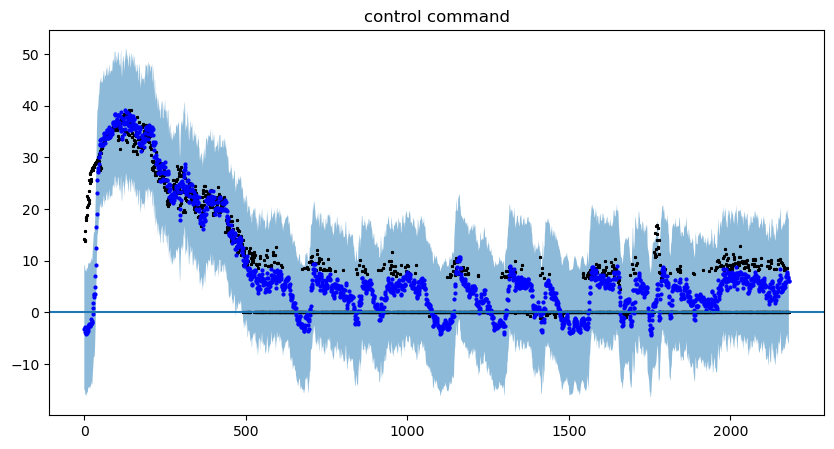

In [78]:
%matplotlib inline


t = np.linspace(0, y_dn.shape[0], y_dn.shape[0])



with torch.no_grad():
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(1, 1, 1)

        # Get upper and lower confidence bounds
#         lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
    ax.plot(t, y_dn, 'k*', markersize=2, label='predictions')
        # Plot predictive means as blue line
    ax.plot(t, p_dn, 'bo', markersize=2, label='observed data')
        # Shade between the lower and upper confidence bounds
#         ax.plot(overlap_t, overlap_y[:, i], "rx", markersize=20, label='overlap between trainset and testset')
    ax.set_title("control command")
    ax.axhline(0)
    ax.fill_between(t, l_dn, u_dn, alpha=0.5)


In [79]:
class MeanVarModelWrapper(torch.nn.Module):
    def __init__(self, gp):
        super().__init__()
        self.gp = gp

    def forward(self, x):
        output_dist = self.gp(x)
        return output_dist.mean, output_dist.variance

In [88]:
print(x_tensor_t.shape)

torch.Size([2181, 7])


In [89]:
wrapped_model = MeanVarModelWrapper(model)

with torch.no_grad(), gpytorch.settings.trace_mode():
    fake_input = torch.tensor([-1, 0.563417, 0.178985, 0.678668, 0.0574563, -0.973333, -0.36]).reshape(1, 7)
    pred = wrapped_model(fake_input)  # Compute caches
    print(pred)
    traced_model = torch.jit.trace(wrapped_model, fake_input)

(tensor([0.3522]), tensor([0.1036]))


In [82]:
# if torch.cuda.is_available():
#     traced_model.save('longitudinal_dynamics_svgp_gpu.pt')
# else:
traced_model.save('longitudinal_dynamics_svgp_cpu.pt')

In [83]:
x_shifter

array([  0. ,   0. , -70. ,  -0.3,  -5. ,  -0.3,  -5. ])

In [84]:
x_normalizer

array([4300. ,   24. ,  255. ,   22.5,   10. ,   22.5,   10. ])

In [85]:
y_shifter

array([-60])

In [86]:
y_normalizer

array([120])

In [90]:
(0.3522 + 1.0) / 2.0 * 120 - 60

21.132000000000005

In [94]:
DeNormalizeData(torch.tensor([-1, 0.563417, 0.178985, 0.678668, 0.0574563, -0.973333, -0.36], dtype=torch.float).reshape(1, 7).numpy(), x_shifter, x_normalizer)

array([[ 0.00000000e+00,  1.87610035e+01,  8.03205875e+01,
         1.85850152e+01,  2.87281275e-01,  3.73721123e-06,
        -1.80000007e+00]])

In [92]:
3.73721123e-06

3.73721123e-06